# Meu notebook de portifólio de quando eu fui contratado
Disclaimer: Na época, eu era muito mais inexperiente. Você vai notar nesse notebook muitas coisas feitas de forma desnecessariamente complexa ou coisas que não eram necessárias de serem realizadas.

O que eu quero passar aqui é como eu, na época, busquei análises que fossem úteis para a solução do problema, e como eu discuti esses resultados no relatório <a href="report.pdf">anexo</a>

Com certeza, com as aulas, você será capaz de fazer um notebook muito melhor que esse para a sua entrevista!

In [1]:
%matplotlib inline

import sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados

Para que o notebook não ficasse poluído para o entrevistador, eu encapsulei algumas análises em outros arquivos, outras funções. Nesse caso, essa função get_data volta a tabela dos dados,e uma lista com os nomes das colunas.
Mostrar que você tem organização em separar seu código em arquivos de "contextos" diferentes pode ser atrativo: é algo que ajuda depois na entrega e produtivização dos modelos
``` python
def getData(name):
    train = pd.read_csv(name)

    names = []
    for n,k in enumerate(train.columns):
        names.append( k )

    return names, train.as_matrix()
```

In [2]:
import preprocessing as prp
names, train_raw = prp.getData('cs-training.csv')
ncols = len(names)
names2, test_raw = prp.getData('cs-test.csv')

## Remover dados não informados (NaN), saturando-os
        

### Como não foram fornecidas informações do MOTIVO do dado não ter sido informado, eu assumi que há um motivo para tal: O cliente poderia estar tentando ESCONDER a informação. Assim, os acumulei como outliers.

        Number of dependents(col 11): Acumulado como outlier máximo (muitos dependentes)
Racional: Uma pessoa com muitos dependentes deve ter menos acesso a crédito: Motivo para esconder a informação
Nota: Essa NÃO é a hipótese que eles costumam fazer! Mas eu fiz uma, soube justificar. A forma como eles trabalham depois é discutida no dia-a-dia

        Monthly Income (col 6): Acumulado como outlier mínimo (pouca renda)
Racional: Tentativa de "esconder" a renda caso esteja desempregado ou coisa assim

<hr />

Nessa época, eu era menos proficiente em pandas, há formas MUITO mais simples de fazer o que eu fiz com ferramentas mais adequadas. Mas note que não conhecer o detalhe de uma ferramenta não me impediu de ser contratado. O importante foi mostrar que eu sabia o que estava fazendo, e porque eu estava fazendo dessa forma
A função que faz isso é essa:
```python
def saturateNaN(dataMat, modedef='min', mode={}, sats=None):
    output = dataMat.copy()
    l,c = np.where(np.isnan(dataMat))
    cols = list(set(c.tolist()))

    # SeriousDlqin2yrs
    if 1 in cols:
        cols.remove(1)

    saturationCol = np.zeros(len(cols))

    for n,c in enumerate(cols):
        col = dataMat[:,c]
        locs, = np.where( np.isnan(col) )
        col = col[ ~np.isnan(col) ]
        if c not in mode.keys():
            modeloc = modedef
        else:
            modeloc = mode[c]
        if modeloc == 'min' and sats is None:
            m = col.min()
            r = np.percentile(col,1)
            if r == 0:
                r = 1
            output[locs,c] = m - r
            saturationCol[n] = m - r
        elif modeloc == 'max' and sats is None:
            m = col.max()
            r = np.percentile(col,1)
            if r == 0:
                r = 1
            output[locs,c] = m + r
            saturationCol[n] = m + r
        elif sats is not None:
            if sats[n] == 0:
                print('error satCol %s %s'%(repr(sats), repr(sats[n])))
            output[locs,c] = sats[n]
    if sats is None:
        return saturationCol, output
    else:
        return output
   ```

In [3]:
satCol, train = prp.saturateNaN(train_raw, mode={11:'max', 6:'min'})
test = prp.saturateNaN(train_raw, mode={11:'max', 6:'min'}, sats=satCol)

## Salvar coluna contendo as classes

Pra facilitar, coloquei num lugar só a forma de acessar todos da classe 0 (não inadimplentes) e todos da classe 1 (inadimplentes)
```python
def getClasses(classCol):
    locs1 = classCol == 0
    locs2 = classCol == 1
    classes = [locs1, locs2]
    return classes
```

In [4]:
classes = prp.getClasses(train[:,1])

## Saturar outliers baseado no percentil (1/99)

Algumas técnicas de machine learning, são muito sensíveis e dados com valores muito diferentes da maioria. Um bom exemplo disso é no caso de renda: No Brasil há umas poucas pessoas com renda superior a alguns milhões, mas a maior parte possui uma renda inferior a mil reais. Isso faz a renda per capita do país ser de quase R$1500,00, o que não reflete a realidade, devido ao tamanho da desigualdade.

Há várias formas de lidar com esse efeito de valores muito distantes da distribuição (chamados de <i>outliers</i>). Aqui eu optei por SATURÁ-LOS. O top 1\% da base seria substituído pelo valor do menor membro dessa categoria.

Uma outra opção seria RETIRAR esses dados da base treino.

``` python
def saturate_outliers(data, perc=1, outs=None):
    if outs is None:
        minval, maxval = np.percentile(data, [perc, 100-perc])
    else:
        minval = outs[0]
        maxval = outs[1]
    bool_arr = np.logical_and(data>minval, data<maxval)
    data[ data<=minval ] = minval
    data[ data>=maxval ] = maxval
    if outs is None:
        return [minval, maxval], data
    else:
        return data

```

In [5]:
trainNO = train.copy()
outCol = []
for n in range(2, train.shape[1]):
    outs, trainNO[:,n] = prp.saturate_outliers(train[:,n], perc=1)
    outCol.append( outs )
testNO = test.copy()
for n in range(2, test.shape[1]):
    testNO[:,n] = prp.saturate_outliers(test[:,n], perc=1, outs=outCol[n-2])

## Escalar dados baseado no desvio padrão

Algumas técnicas de Machine Learning pedem que os dados seja escalados para ter média 0 e desvio padrão 0. Isso é feito simplesmente subtraindo uma constante e dividindo por outra constante, não muda a forma como os dados se relacionam.

Esse tratamento foi importante para o próximo passo, foi fiz uma análise de componentes principais para levantar algumas hipóteses sobre as causas da inadimplência.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
trainS = scaler.fit_transform(trainNO[:,2:])
testS = scaler.transform(testNO[:,2:])

# Visualização inicial dos dados

### Plot de todos os dados, deixando os de classe=1 (Inadimplentes) plotados no final de outra cor

A finalidade desse plot e ver se não sobraram outliers, ou se algum pedaço específico dos dados não apresentava algum comportamento "estranho", que pudesse levantar outras hipóteses

<IPython.core.display.Javascript object>


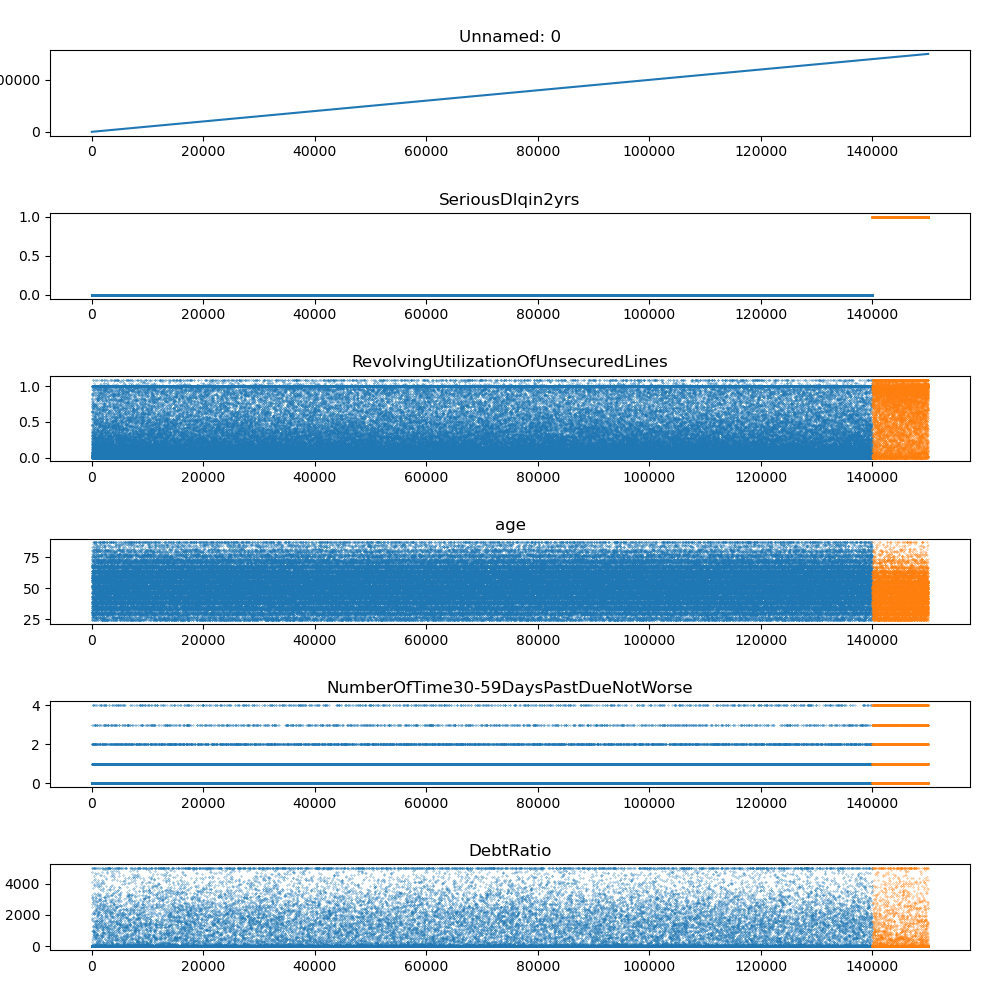

<IPython.core.display.Javascript object>


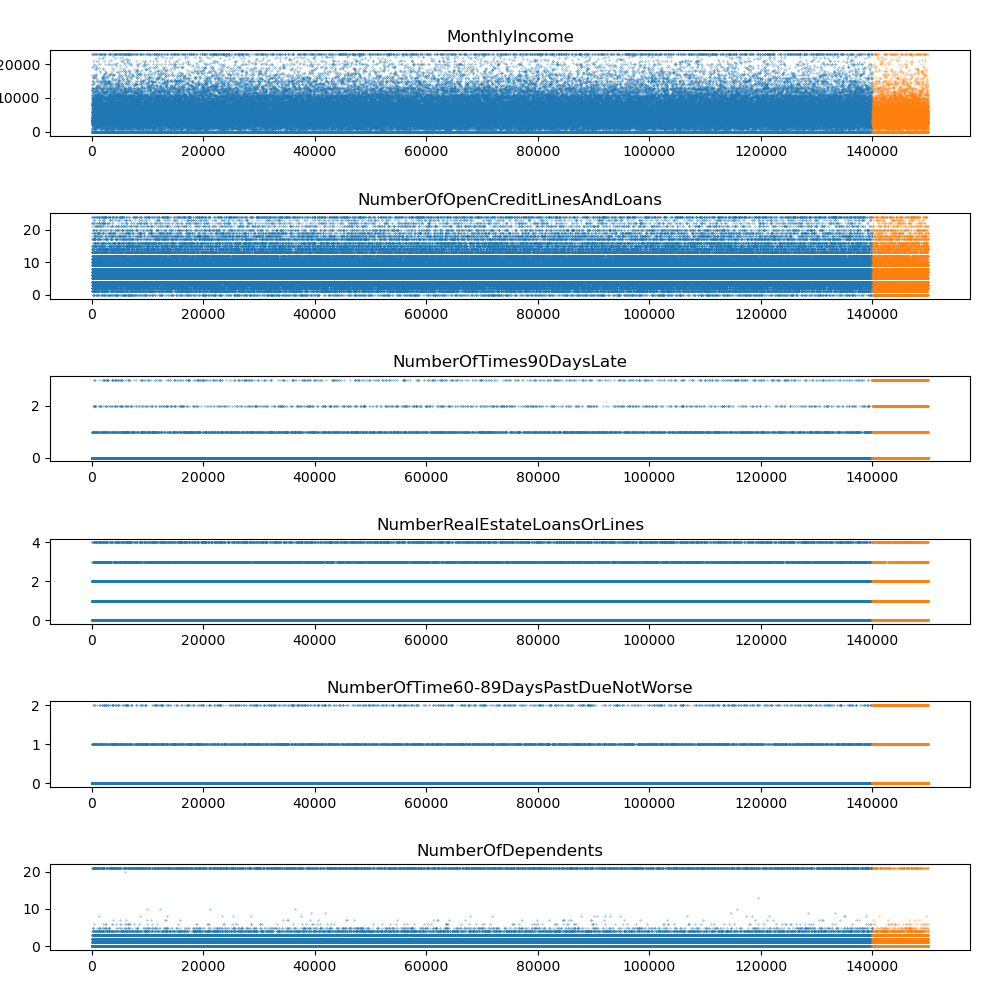

In [7]:
ax = []

fig1 = plt.figure(figsize=(10,10))
ax.append(fig1.add_subplot(611))
ax.append(fig1.add_subplot(612,sharex=ax[0]))
ax.append(fig1.add_subplot(613,sharex=ax[0]))
ax.append(fig1.add_subplot(614,sharex=ax[0]))
ax.append(fig1.add_subplot(615,sharex=ax[0]))
ax.append(fig1.add_subplot(616,sharex=ax[0]))
fig2 = plt.figure(figsize=(10,10))
ax.append(fig2.add_subplot(611,sharex=ax[0]))
ax.append(fig2.add_subplot(612,sharex=ax[0]))
ax.append(fig2.add_subplot(613,sharex=ax[0]))
ax.append(fig2.add_subplot(614,sharex=ax[0]))
ax.append(fig2.add_subplot(615,sharex=ax[0]))
ax.append(fig2.add_subplot(616,sharex=ax[0]))

ax[0].plot(train[:,0])
ax[0].set_title( names[0] )

locs = train[:,1] == 0
tam0 = (locs).sum()
tamt = train[:,1].size
for i in range(1,ncols):
    ax[i].plot(np.arange(0,tam0), train[:,i][locs], 'C0.', ms=0.5)
    ax[i].plot(np.arange(tam0,tamt), train[:,i][~locs], 'C1.', ms=0.5)
    ax[i].set_title( names[i] )

fig1.subplots_adjust(top=0.950, bottom=0.050, left=0.050, right=0.970, hspace=0.900, wspace=0.200)
fig2.subplots_adjust(top=0.950, bottom=0.050, left=0.050, right=0.970, hspace=0.900, wspace=0.200)

### Histogramas 

Aqui eu fiz alguns histogramas separadamente para cada classe para entender como as variáveis se distinguem de uma classe para outra. Note que foi necessário normalizar os histogramas (parâmetro `density=True`), pois há muito menos pessoas na classe 1 (inadimplentes) que na classe 0

<IPython.core.display.Javascript object>


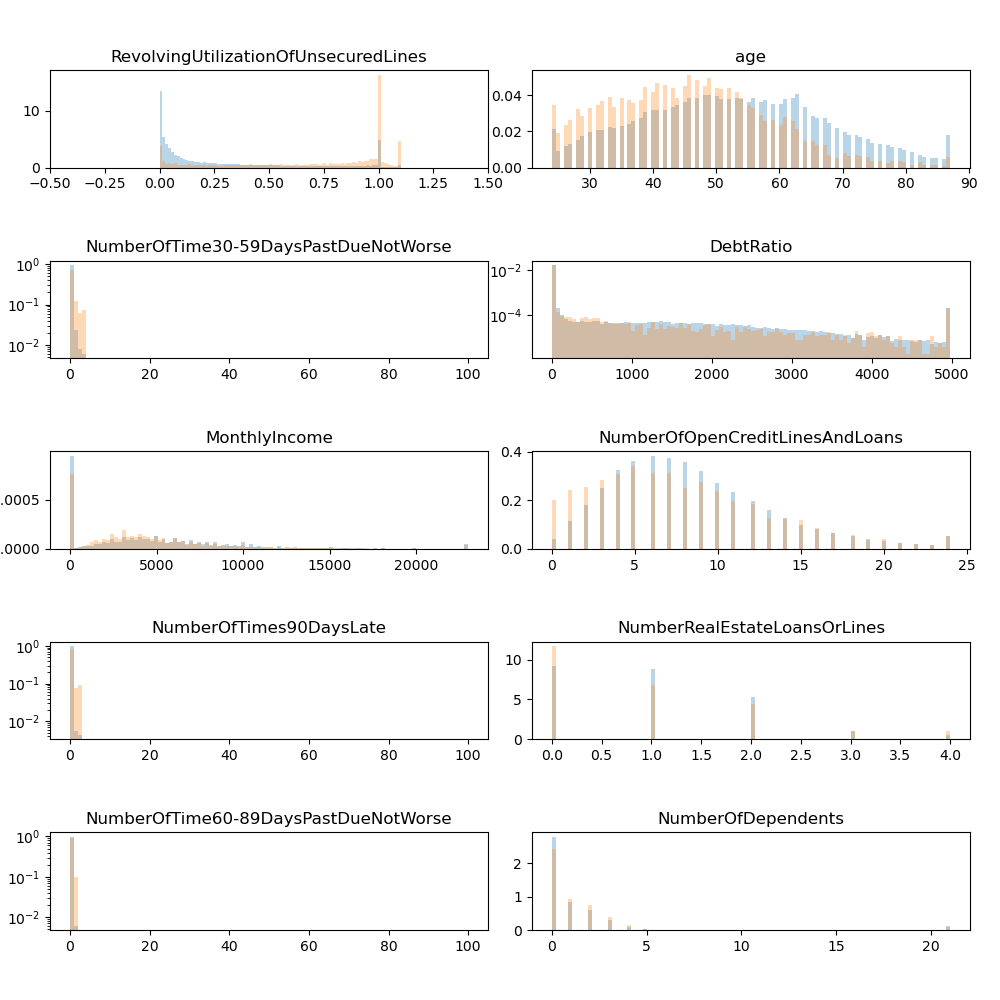

RevolvingUtilizationOfUnsecuredLines
1
(0.0, 1.092955768140002)
(0.0, 1.092955768140002)
(0.0, 1.092955768140002)
----


/usr/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


age
2
(24.0, 87.0)
(24.0, 87.0)
(24.0, 87.0)
----
NumberOfTime30-59DaysPastDueNotWorse
3
(0.0, 4.0)
(0.0, 4.0)
(0.0, 4.0)
----
DebtRatio
4
(0.0, 4979.040000000037)
(0.0, 4979.040000000037)
(0.0, 4979.040000000037)
----
MonthlyIncome
5
(-1.0, 23000.0)
(-1.0, 23000.0)
(-1.0, 23000.0)
----
NumberOfOpenCreditLinesAndLoans
6
(0.0, 24.0)
(0.0, 24.0)
(0.0, 24.0)
----
NumberOfTimes90DaysLate
7
(0.0, 3.0)
(0.0, 3.0)
(0.0, 3.0)
----
NumberRealEstateLoansOrLines
8
(0.0, 4.0)
(0.0, 4.0)
(0.0, 4.0)
----
NumberOfTime60-89DaysPastDueNotWorse
9
(0.0, 2.0)
(0.0, 2.0)
(0.0, 2.0)
----
NumberOfDependents
10
(0.0, 21.0)
(0.0, 21.0)
(0.0, 21.0)
----


In [9]:
nbins = 100

fig = plt.figure(figsize=(10,10))
ax = []
for i in range(1,ncols-1):
    ax.append(fig.add_subplot(5,2,i))
    data = train[:,i+1]
    locs0 = classes[0].copy()
    locs1 = classes[1].copy()
    print(names[i+1])
    print(i)
    print( (data.min(), data.max()) )
    print( (data[locs0].min(), data[locs0].max()) )
    print( (data[locs1].min(), data[locs1].max()) )
    print('----')
    if i+1 not in [2, 4, 5, 8, 10]:
        ax[-1].hist(data[locs0], color='C0', alpha=0.3, density=True, bins=nbins)
        ax[-1].hist(data[locs1], color='C1', alpha=0.3, density=True, bins=nbins)
    elif i+1 in [2]:
        bins = np.concatenate( (np.linspace(0,1.3,nbins), np.array([1.3,100000]) ))
        ax[-1].hist(data[locs0], color='C0', alpha=0.3, density=True, bins=bins)
        ax[-1].hist(data[locs1], color='C1', alpha=0.3, density=True, bins=bins)
        ax[-1].set_xlim( (-0.5,1.5) )
    elif i+1 in [5]:
        ax[-1].hist(data[locs0], color='C0', alpha=0.3, density=True, bins=nbins, log=True)
        ax[-1].hist(data[locs1], color='C1', alpha=0.3, density=True, bins=nbins, log=True)
    elif i+1 in [4, 8, 10]:
        ax[-1].hist(data[locs0], color='C0', alpha=0.3, density=True, bins=np.linspace(0,100,nbins), log=True)
        ax[-1].hist(data[locs1], color='C1', alpha=0.3, density=True, bins=np.linspace(0,100,nbins), log=True)
    else:
        print('ERROR ----------------')
    ax[-1].set_title( names[i+1] )

fig.subplots_adjust(left=0.050, bottom=0.070, right=0.970, top=0.930, hspace=0.950, wspace=0.100)

<IPython.core.display.Javascript object>


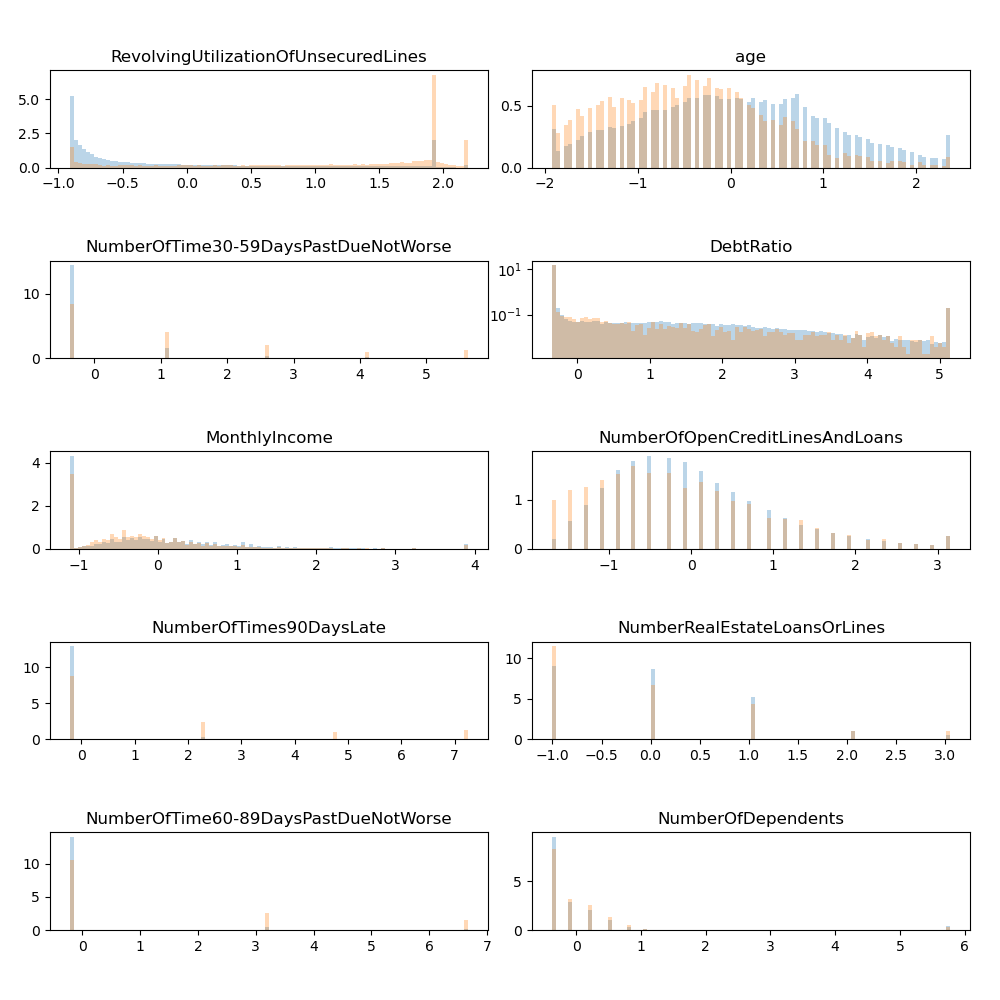

RevolvingUtilizationOfUnsecuredLines
0
(-0.9101088088418748, 2.193547957572049)
(-0.9101088088418748, 2.193547957572049)
(-0.9101088088418748, 2.193547957572049)
----
age
1
(-1.9279487027987299, 2.367098914300161)
(-1.9279487027987299, 2.367098914300161)
(-1.9279487027987299, 2.367098914300161)
----
NumberOfTime30-59DaysPastDueNotWorse
2
(-0.3687090890498316, 5.629974536588037)
(-0.3687090890498316, 5.629974536588037)
(-0.3687090890498316, 5.629974536588037)
----
DebtRatio
3
(-0.3490221717390298, 5.140794800066126)
(-0.3490221717390298, 5.140794800066126)
(-0.3490221717390298, 5.140794800066126)
----
MonthlyIncome
4
(-1.1086480368695169, 3.9180343603198593)
(-1.1086480368695169, 3.9180343603198593)
(-1.1086480368695169, 3.9180343603198593)
----
NumberOfOpenCreditLinesAndLoans
5
(-1.6990192903421204, 3.153011048569218)
(-1.6990192903421204, 3.153011048569218)
(-1.6990192903421204, 3.153011048569218)
----
NumberOfTimes90DaysLate
6
(-0.21531686936853145, 7.2534714768766815)
(-0.2153168693

In [10]:
nbins = 100

fig = plt.figure(figsize=(10,10))
ax = []
for i in range(trainS.shape[1]):
    ax.append(fig.add_subplot(5,2,i+1))
    data = trainS[:,i]
    locs0 = classes[0].copy()
    locs1 = classes[1].copy()
    print(names[i+2])
    print(i)
    print( (data.min(), data.max()) )
    print( (data[locs0].min(), data[locs0].max()) )
    print( (data[locs1].min(), data[locs1].max()) )
    print('----')
    if i+1 not in np.array([4]):
        ax[-1].hist(data[locs0], color='C0', alpha=0.3, density=True, bins=nbins)
        ax[-1].hist(data[locs1], color='C1', alpha=0.3, density=True, bins=nbins)
    elif i+1 in np.array([4]):
        ax[-1].hist(data[locs0], color='C0', alpha=0.3, density=True, bins=nbins, log=True)
        ax[-1].hist(data[locs1], color='C1', alpha=0.3, density=True, bins=nbins, log=True)
    ax[-1].set_title( names[i+2] )

fig.subplots_adjust(left=0.050, bottom=0.070, right=0.970, top=0.930, hspace=0.950, wspace=0.100)

### Matriz de correlação

A correlação nos diz muito como os dados se comportam:

 Por exemplo MonthlyIncome é negativamente correlaionada com DebtRatio, quer dizer que quanto maior a renda, menor a razão da dívida pela renda.
 
Algumas técnicas exigem que se removam variáveis com correlação muito alta (acima de 80\%, por exemplo) para funcionarem

<IPython.core.display.Javascript object>


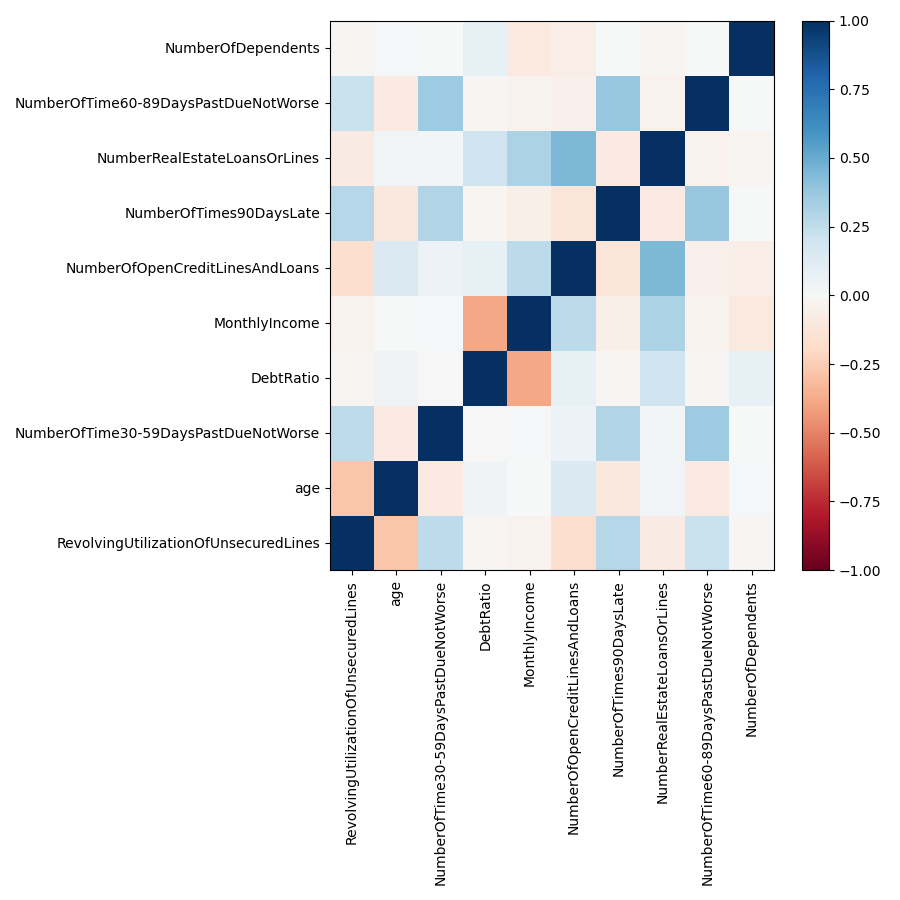

In [11]:
corrMat = np.corrcoef(trainS.T)

fig = plt.figure(figsize=(9,9))
plt.pcolormesh(corrMat, vmin=-1, vmax=1, cmap='RdBu')
plt.colorbar()

ax = fig.get_axes()[0]
ax.set_xticks(0.5+np.arange(trainS.shape[1]))
ax.set_yticks(0.5+np.arange(trainS.shape[1]))
ax.set_xticklabels(names[2:], rotation='vertical')
ax.set_yticklabels(names[2:], rotation='horizontal')

plt.tight_layout()

## PCA

A análise de componentes principais é uma técnica de redução de dimensionalidade. Isso significa que ela me permitiu "enxergar" meu dados em um espaço de 3 dimensões, que eu consigo ver as projeções por meio de 3 gráficos.

O que ela faz é criar as melhores combinações das variáveis para permitir essa visualização. Combinações lineares: Cada variável é multiplicada por uma constante, depois todas elas se somam. Pelo valor dessas constantes, eu levantei algumas hipóteses no relatório

NumberOfTimes90DaysLate
RevolvingUtilizationOfUnsecuredLines	0.43340
                                age	-0.27106
NumberOfTime30-59DaysPastDueNotWorse	0.35953
                          DebtRatio	-0.03575
                      MonthlyIncome	-0.20304
    NumberOfOpenCreditLinesAndLoans	-0.32596
            NumberOfTimes90DaysLate	0.45310
       NumberRealEstateLoansOrLines	-0.28470
NumberOfTime60-89DaysPastDueNotWorse	0.41575
                 NumberOfDependents	0.03845
------------------------------
MonthlyIncome
RevolvingUtilizationOfUnsecuredLines	0.13203
                                age	-0.03820
NumberOfTime30-59DaysPastDueNotWorse	0.36297
                          DebtRatio	-0.12528
                      MonthlyIncome	0.49749
    NumberOfOpenCreditLinesAndLoans	0.47197
            NumberOfTimes90DaysLate	0.18592
       NumberRealEstateLoansOrLines	0.48391
NumberOfTime60-89DaysPastDueNotWorse	0.26844
                 NumberOfDependents	-0.15042
------------------------------
DebtRa

<IPython.core.display.Javascript object>


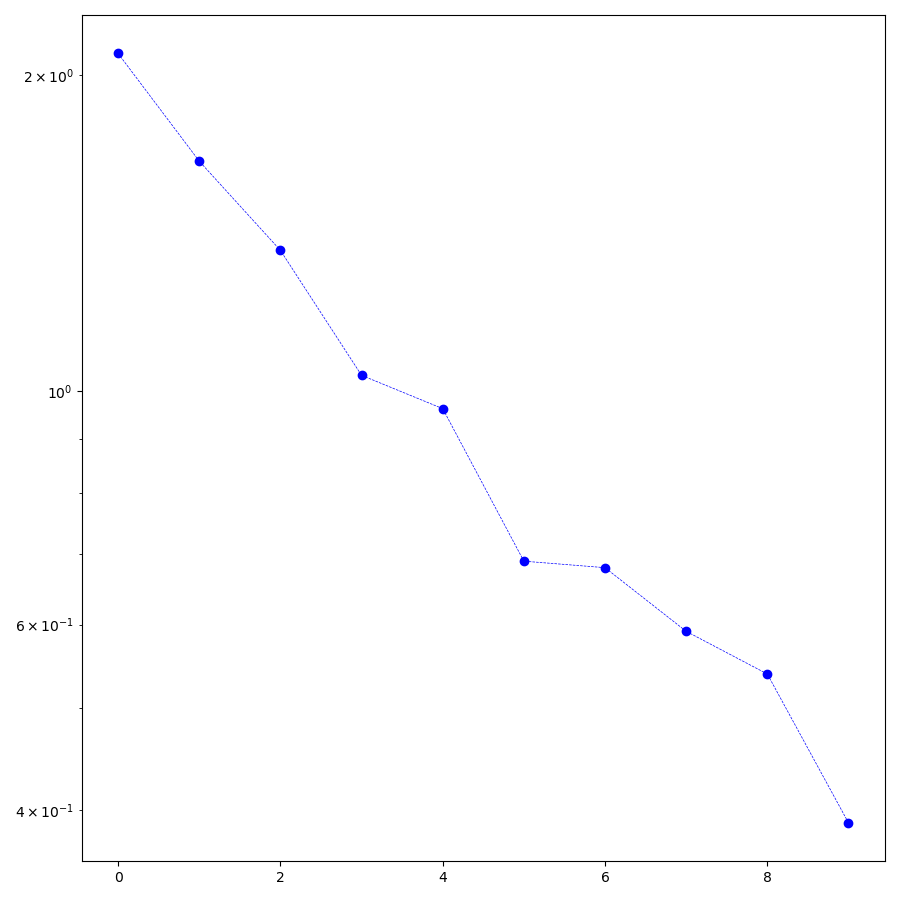

<IPython.core.display.Javascript object>


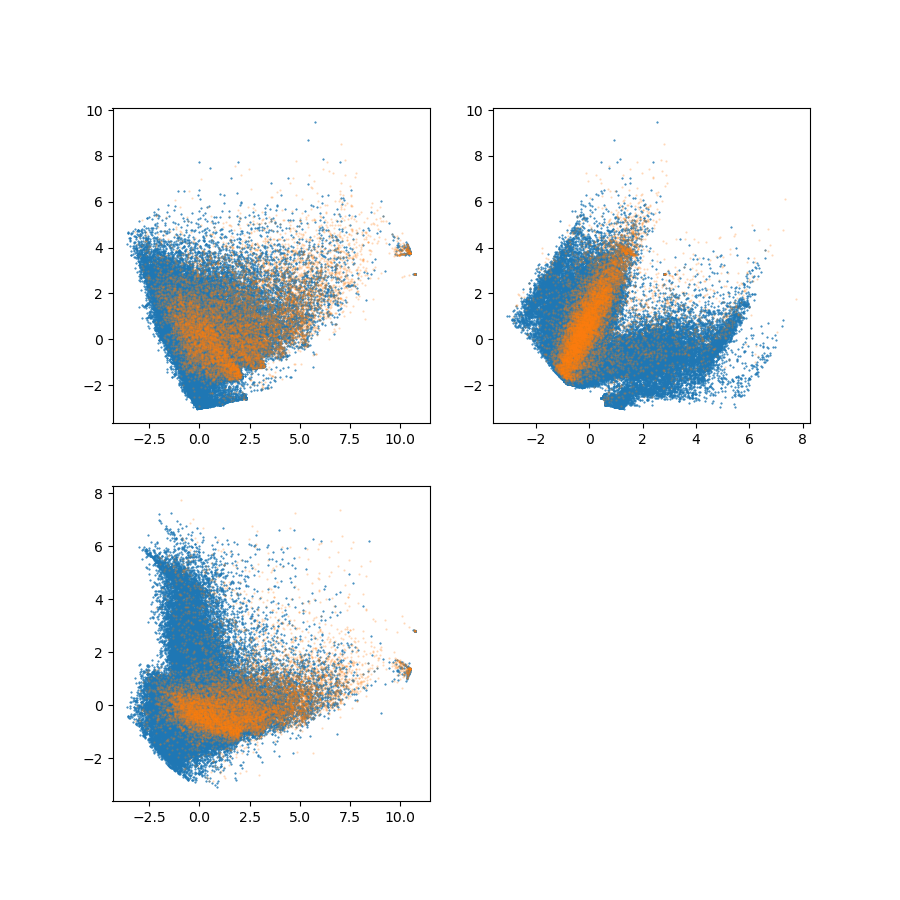

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
PCAout = pca.fit_transform(trainS)

C = pca.components_
print( names[ 2+np.abs(C[0]).argmax() ] )
for n in range(C[0].size):
    print('%35s\t%.5f'%(names[2+n],C[0][n]))
print('------------------------------')
print( names[ 2+np.abs(C[1]).argmax() ] )
for n in range(C[1].size):
    print('%35s\t%.5f'%(names[2+n],C[1][n]))
print('------------------------------')
print( names[ 2+np.abs(C[2]).argmax() ] )
for n in range(C[2].size):
    print('%35s\t%.5f'%(names[2+n],C[2][n]))
print('------------------------------')

plt.figure(figsize=(9,9))
plt.semilogy(pca.explained_variance_, 'bo')
plt.semilogy(pca.explained_variance_, 'b--', lw=0.5)
plt.tight_layout()

plt.figure(figsize=(9,9))
plt.tight_layout()
ax1 = plt.subplot(221)
plt.plot(PCAout[:,0][locs0],PCAout[:,1][locs0], 'C0.', ms=1)
plt.plot(PCAout[:,0][locs1],PCAout[:,1][locs1], 'C1.', ms=1, alpha=0.3)
ax2 = plt.subplot(222, sharey=ax1)
plt.plot(PCAout[:,2][locs0],PCAout[:,1][locs0], 'C0.', ms=1)
plt.plot(PCAout[:,2][locs1],PCAout[:,1][locs1], 'C1.', ms=1, alpha=0.3)
ax3 = plt.subplot(223, sharex=ax1)
plt.plot(PCAout[:,0][locs0],PCAout[:,2][locs0], 'C0.', ms=1)
plt.plot(PCAout[:,0][locs1],PCAout[:,2][locs1], 'C1.', ms=1, alpha=0.3)

## Testar alguns classificadores

Essa é uma mania de iniciantes que eu tinha na época. Sair testando toneladas de classificadores. Isso pode ser bom para competições, mas vocês vão notar pelas curvas ROC abaixo, que eles mudam pouco de um pro outro. Será que compensa o tempo todo gasto no treinamento?

Além disso, o código está bem complexo, se você acompanhou os vídeos, sabe que há formas mais simples de fazer esse teste do que eu fiz na época

In [13]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import AdaBoostClassifier, \
                            GradientBoostingClassifier, \
                            RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

params = {}
params['AdaBoost'] =        [ np.array([50,100,200,300,400]), np.array([0.5,0.75,1.0,1.5,2.0]) ]
params['GaussianNB'] =      [ np.array([1]) ]
params['GradientBoost_dev'] =   [ np.array([300,400,500,600]), np.array([0.01,0.05,0.1,0.5,1.0,1.5]) ]
params['GradientBoost_exp'] =   [ np.array([300,400,500,600]), np.array([0.01,0.05,0.1,0.5,1.0,1.5]) ]
params['KNeighbors'] =      [ np.array([5,7,9,11,13,15]) ]
params['RandomForest_g'] =  [ np.array([2,3,5,7,9,11,12]) ]
params['RandomForest_e'] =  [ np.array([2,3,5,7,9,11,12]) ]

classis = {}
classis['AdaBoost'] = lambda x,y: AdaBoostClassifier(n_estimators=x, learning_rate=y)
classis['GaussianNB'] = lambda x: GaussianNB()
classis['GradientBoost_dev'] = lambda x,y: GradientBoostingClassifier(loss='deviance', learning_rate=y, n_estimators=x, max_depth=3, criterion='friedman_mse')
classis['GradientBoost_exp'] = lambda x,y: GradientBoostingClassifier(loss='exponential', learning_rate=y, n_estimators=x, max_depth=3, criterion='friedman_mse')
classis['KNeighbors'] = lambda x: KNeighborsClassifier(n_neighbors=x, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
classis['RandomForest_g'] = lambda x: RandomForestClassifier(max_depth=x, criterion='gini')
classis['RandomForest_e'] = lambda x: RandomForestClassifier(max_depth=x, criterion='entropy')

def apply_classifiers(classis, params):
    for k in params.keys():
        print('model: %s'%(k))
        if len(params[k]) == 1:
            best = -1
            bestx = -1
            for x in params[k][0]:
                sys.stdout.write('\t\t%.3f\r'%(x))
                sys.stdout.flush()
                C = classis[k](x)
                scores = cross_val_score(C, trainS, train[:,1], cv=5, n_jobs=-1, scoring='roc_auc')
                if scores.mean() > best:
                    best = scores.mean()
                    bestx = x
            print('\n%20s\t%.3f\t%.3f'%(k, bestx, best))
        elif len(params[k]) == 2:
            best = -1
            bestx = -1
            besty = -1
            for x in params[k][0]:
                for y in params[k][1]:
                    sys.stdout.write('\t\t%.3f\t%.3f\r'%(x,y))
                    sys.stdout.flush()
                    C = classis[k](x,y)
                    scores = cross_val_score(C, trainS, train[:,1], cv=5, n_jobs=-1, scoring='roc_auc')
                    if scores.mean() > best:
                        best = scores.mean()
                        bestx = x
                        besty = y
            print('\n%20s\t%.3f\t%.3f\t%.3f'%(k, bestx, besty, best))
            
Y = train[:,1]
print('prior: (%d) %.3f\t(%d) %.3f'%(0, (Y==0).sum()/Y.size, 1, (Y==1).sum()/Y.size))
apply_classifiers(classis,params)

prior: (0) 0.933	(1) 0.067
model: AdaBoost
		400.000	2.000
            AdaBoost	100.000	0.750	0.860
model: GaussianNB
		1.000
          GaussianNB	1.000	0.846
model: GradientBoost_dev
		600.000	1.500
   GradientBoost_dev	500.000	0.050	0.865
model: GradientBoost_exp
		600.000	1.500
   GradientBoost_exp	400.000	0.050	0.866
model: KNeighbors
		15.000
          KNeighbors	15.000	0.803
model: RandomForest_g
		12.000
      RandomForest_g	11.000	0.864
model: RandomForest_e
		12.000
      RandomForest_e	11.000	0.864


## Determinar limiar utilizando curva ROC

De novo, há formas MUITO mais simples de se fazer esse gráfico.

Ter usado mais programação pra fazer "do jeito mais difícil" não me ajudou. Nem atrapalhou. O que interessa é: Você sabe o que está fazendo? Sabe onde quer chegar?

AdaBoostClassifier(learning_rate=0.75, n_estimators=200)


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


fpr:0.212	tpr:0.773	thres:0.495
GradientBoostingClassifier(learning_rate=0.05, n_estimators=600)


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


fpr:0.212	tpr:0.786	thres:0.062
RandomForestClassifier(max_depth=2000)


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


fpr:0.212	tpr:0.748	thres:0.071


<ipython-input-18-b7081b8d5def>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  thres.append(interp(mean_fpr, fpr, thresholds))
<ipython-input-18-b7081b8d5def>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


<IPython.core.display.Javascript object>


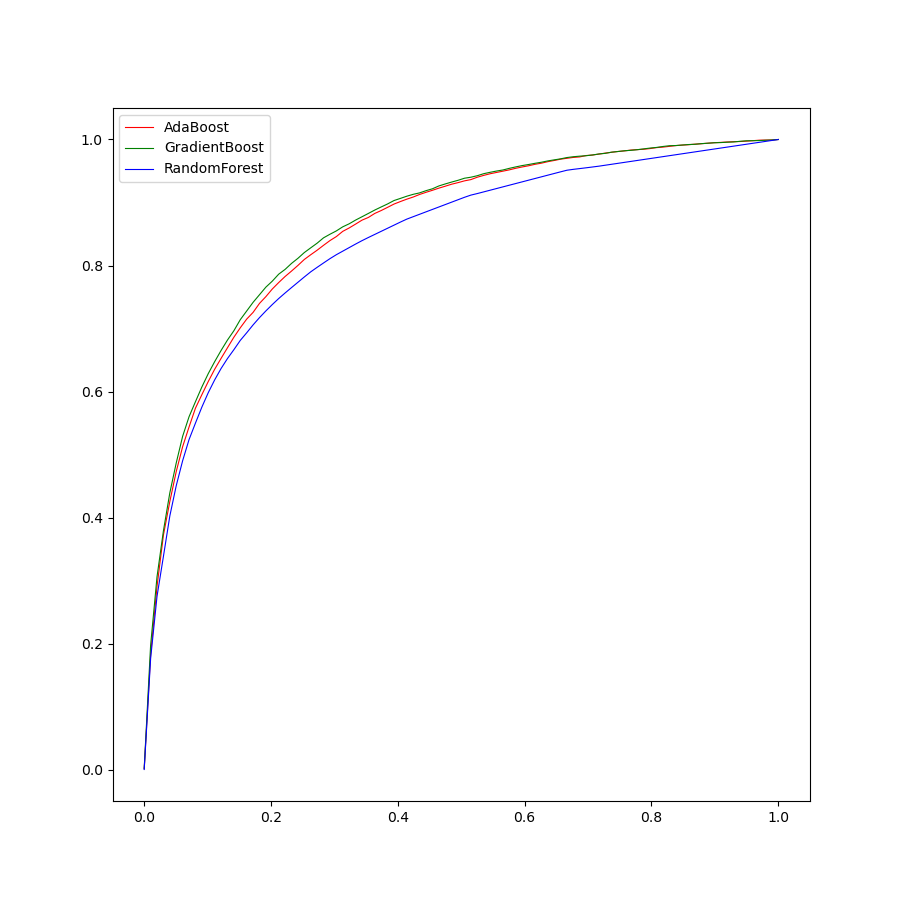

In [18]:
from sklearn.ensemble import AdaBoostClassifier, \
                                GradientBoostingClassifier, \
                                RandomForestClassifier
        
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from scipy import interp
import sys

adaC = AdaBoostClassifier(n_estimators=200, learning_rate=0.75)
gbC = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=600, max_depth=3, criterion='friedman_mse')
rfC = RandomForestClassifier(max_depth=2000, criterion='gini')

cv = StratifiedKFold(n_splits=5)

def roc(C,trainS,train):
    print(C)
    
    tprs = []
    thres = []
    mean_fpr = np.linspace(0, 1, 100)
    
    X = trainS
    y = train[:,1]
    for n,(tr,tst) in enumerate(cv.split(X, y)):
        sys.stdout.write('%d\r'%n)
        sys.stdout.flush()
        probas_ = C.fit(X[tr], y[tr]).predict_proba(X[tst])
        fpr, tpr, thresholds = roc_curve(y[tst], probas_[:, 1])
        thres.append(interp(mean_fpr, fpr, thresholds))
        tprs.append(interp(mean_fpr, fpr, tpr))
    mean_tpr = np.mean(tprs, axis=0)
    mean_thres = np.mean(thres,axis=0)

    dists = np.sqrt((0-mean_fpr)**2 + (1-mean_tpr)**2)

    argm = dists.argmin()

    print('fpr:%.3f\ttpr:%.3f\tthres:%.3f'%(mean_fpr[argm], mean_tpr[argm], mean_thres[argm]))

    return mean_fpr,mean_tpr
mean_fpr_ada, mean_tpr_ada = roc(adaC,trainS,train)
mean_fpr_gb, mean_tpr_gb = roc(gbC,trainS,train)
mean_fpr_rf, mean_tpr_rf = roc(rfC,trainS,train)

plt.figure(figsize=(9,9))
plt.plot(mean_fpr_ada,mean_tpr_ada,'r-',lw=0.8, label='AdaBoost')
plt.plot(mean_fpr_gb,mean_tpr_gb,'g-',lw=0.8, label='GradientBoost')
plt.plot(mean_fpr_rf,mean_tpr_rf,'b-',lw=0.8, label='RandomForest')
plt.legend()

## Matriz confusão dos melhores classificadores

ada
gradient
forest
ada
[[102920  37054]
 [  1817   8209]]
[[0.73527941 0.26472059]
 [0.18122881 0.81877119]]
gb
[[110284  29690]
 [  2137   7889]]
[[0.78788918 0.21211082]
 [0.21314582 0.78685418]]
forest
[[109215  30759]
 [  2379   7647]]
[[0.78025205 0.21974795]
 [0.23728306 0.76271694]]


<IPython.core.display.Javascript object>


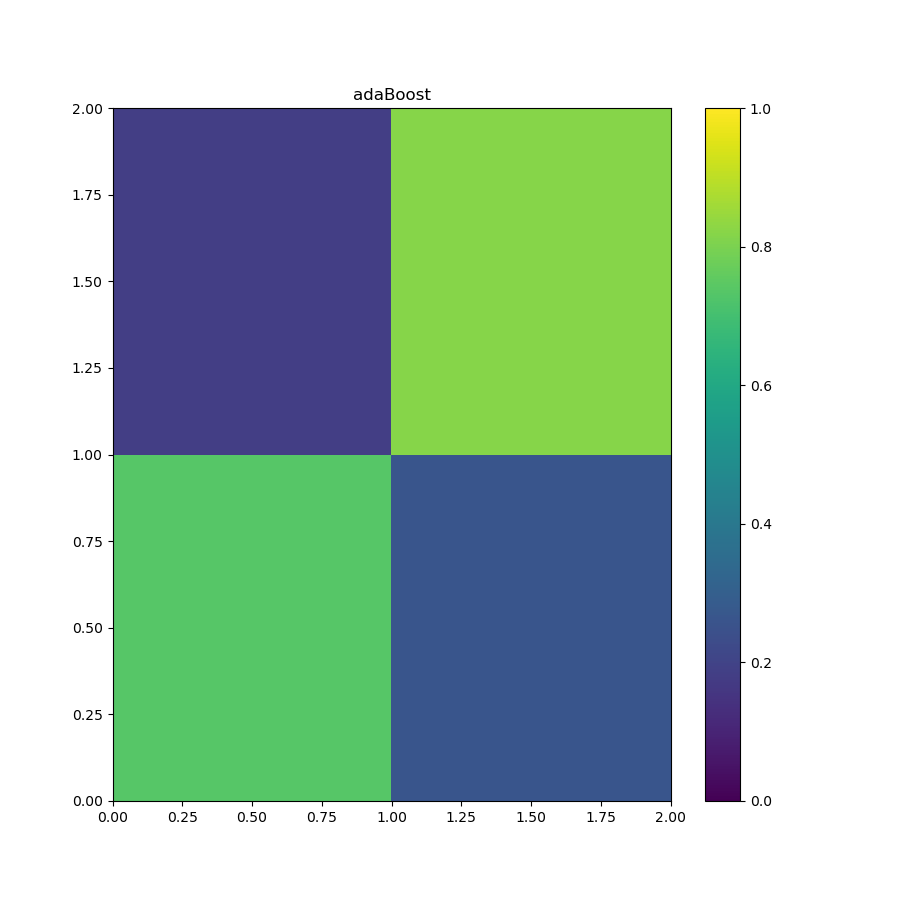

<IPython.core.display.Javascript object>


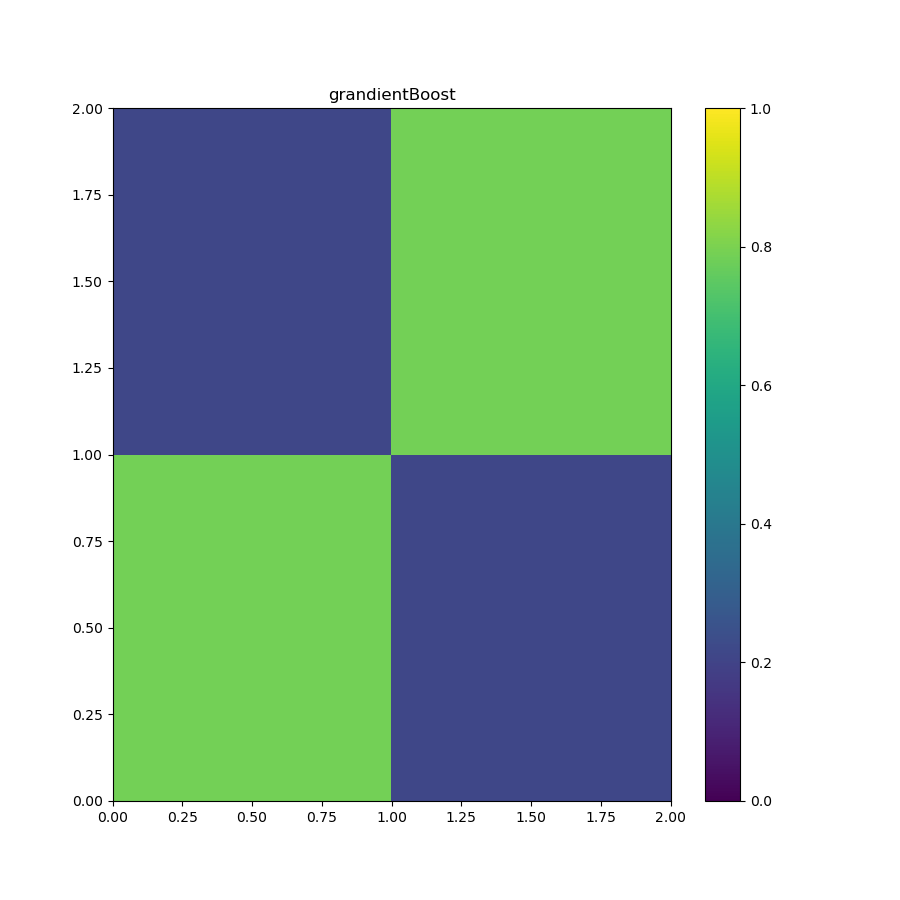

<IPython.core.display.Javascript object>


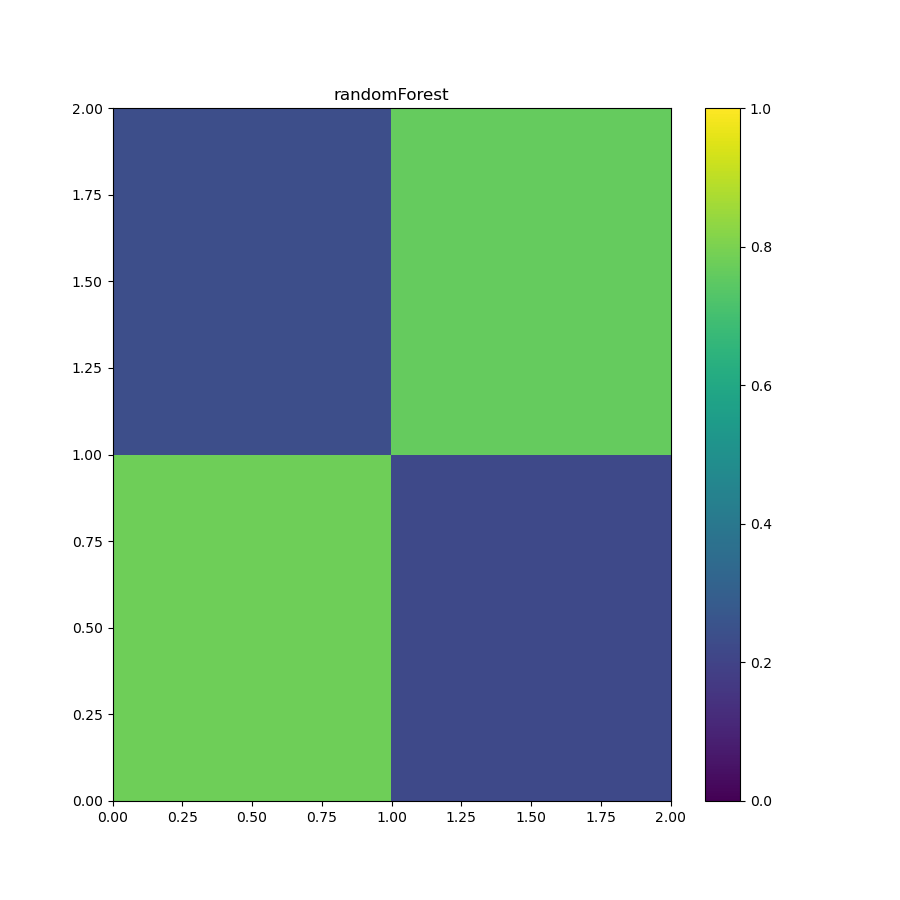

Text(0.5, 1.0, 'randomForest')

In [15]:
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import AdaBoostClassifier, \
                                GradientBoostingClassifier, \
                                RandomForestClassifier

adaC = AdaBoostClassifier(n_estimators=200, learning_rate=0.75)
gbC = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=600, max_depth=3, criterion='friedman_mse')
rfC = RandomForestClassifier(n_estimators=2000, criterion='gini')

def cross_predict(C, X, y, th=0.50, cv=5):
    cv = StratifiedKFold(n_splits=5)
    
    probs = np.array([])
    orig = np.array([])
    for n,(tr,tst) in enumerate(cv.split(X, y)):
        sys.stdout.write('%d\r'%n)
        sys.stdout.flush()
        probas_ = C.fit(X[tr], y[tr]).predict_proba(X[tst])
        orig = np.concatenate( (orig, y[tst]) )
        probs = np.concatenate( (probs, probas_[:,1]) )
    y = np.zeros(probs.size)
    idx1 = probs>th
    y[idx1]=1
    return orig, y

th_ada = 0.495
th_gb = 0.062
th_rf = 0.067

print('ada')
ada_orig, ada_yPred = cross_predict(adaC, X=trainS, y=train[:,1], cv=5, th=th_ada)
print('gradient')
gb_orig, gb_yPred = cross_predict(gbC, X=trainS, y=train[:,1], cv=5, th=th_gb)
print('forest')
rf_orig, rf_yPred = cross_predict(rfC, X=trainS, y=train[:,1], cv=5, th=th_rf)

adaConf = confusion_matrix(ada_orig, ada_yPred)
gbConf = confusion_matrix(gb_orig, gb_yPred)
rfConf = confusion_matrix(rf_orig, rf_yPred)

print('ada')
print(adaConf)
adaConf = adaConf.astype(np.float) / adaConf.sum(axis=1)[:, np.newaxis]
print(adaConf)

print('gb')
print(gbConf)
gbConf = gbConf.astype(np.float) / gbConf.sum(axis=1)[:,np.newaxis]
print(gbConf)

print('forest')
print(rfConf)
rfConf = rfConf.astype(np.float) / rfConf.sum(axis=1)[:,np.newaxis]
print(rfConf)


plt.figure(figsize=(9,9))
plt.pcolormesh(adaConf, vmin=0, vmax=1)
plt.colorbar()
plt.title('adaBoost')

plt.figure(figsize=(9,9))
plt.pcolormesh(gbConf, vmin=0, vmax=1)
plt.colorbar()
plt.title('grandientBoost')

plt.figure(figsize=(9,9))
plt.pcolormesh(rfConf, vmin=0, vmax=1)
plt.colorbar()
plt.title('randomForest')

# Predict probabilities from test group

In [16]:
adaC = AdaBoostClassifier(n_estimators=200, learning_rate=0.75)
gbC = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=600, max_depth=3, criterion='friedman_mse')
rfC = RandomForestClassifier(n_estimators=2000, criterion='gini')

print('ada')
adaC.fit(trainS, train[:,1])
print('gb')
gbC.fit(trainS, train[:,1])
print('rf')
rfC.fit(trainS, train[:,1])

print('ada')
pada = adaC.predict_proba(testS)[:,1]
print('gb')
pgb = gbC.predict_proba(testS)[:,1]
print('rf')
prf = rfC.predict_proba(testS)[:,1]

th_ada = 0.495
th_gb = 0.062
th_rf = 0.067

yada = pada > th_ada
ygb = pgb > th_gb
yrf = prf > th_rf

ada
gb
rf
ada
gb
rf


In [17]:
print(yada.sum()/yada.size)
print(ygb.sum()/ygb.size)
print(yrf.sum()/yrf.size)

0.3025466666666667
0.25034
0.14249333333333333
